In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy 
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Seoul Bike Sharing Demand
Donated on 2/29/2020
The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information

Dataset Characteristics
Multivariate

Subject Area
Business

Associated Tasks
Regression

Feature Type
Integer, Real

# Instances
8760

# Features
13
Source: https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [46]:
dataset_cols = ["bike_count","hour","temp","humidity","wind","visibility","dew_pt_temp","radiation","rain","snow","functional"]
df = pd.read_csv("data/SeoulBikeData.csv", encoding="cp949").drop(["Date","Holiday","Seasons"],axis=1)

In [47]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)


In [48]:
df = df[df["hour"] == 12]
df = df.drop(["hour"],axis=1)

In [49]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


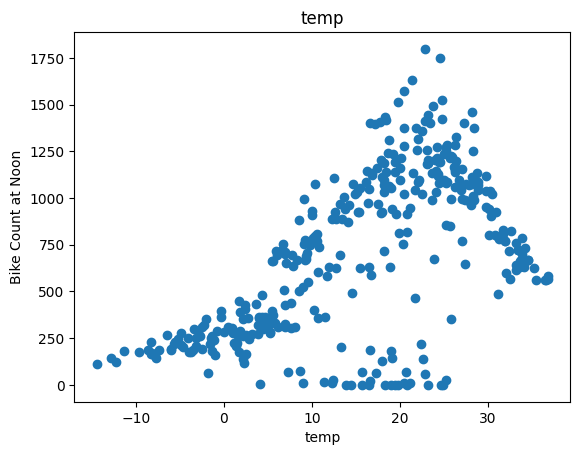

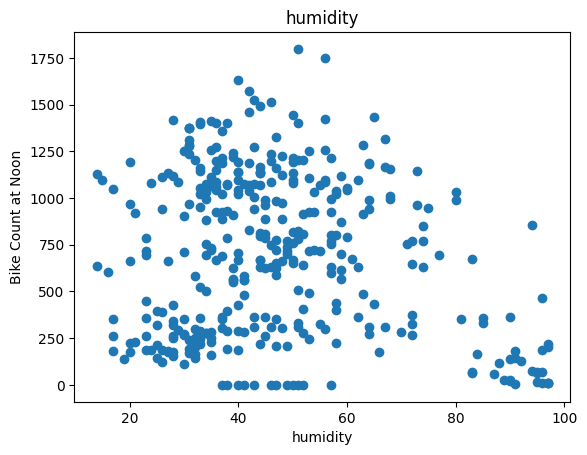

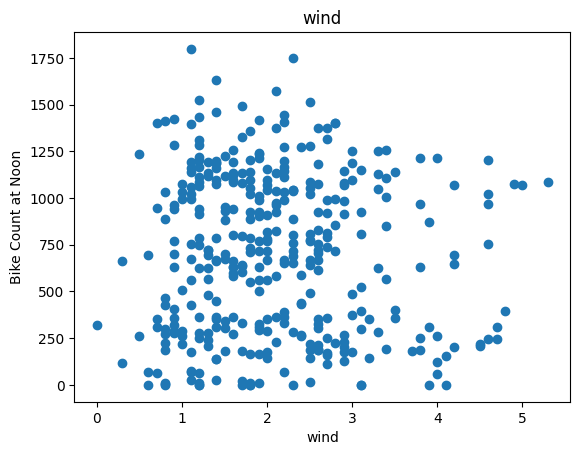

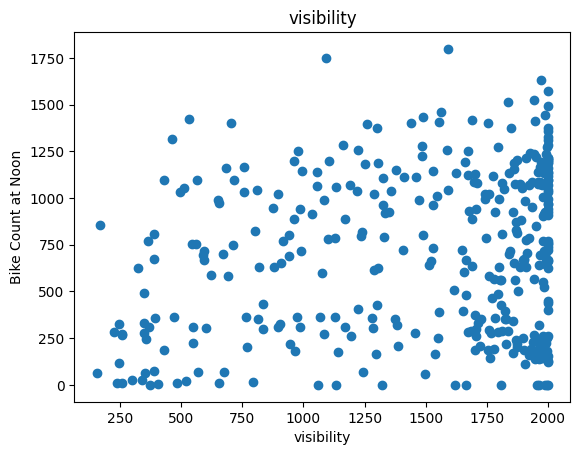

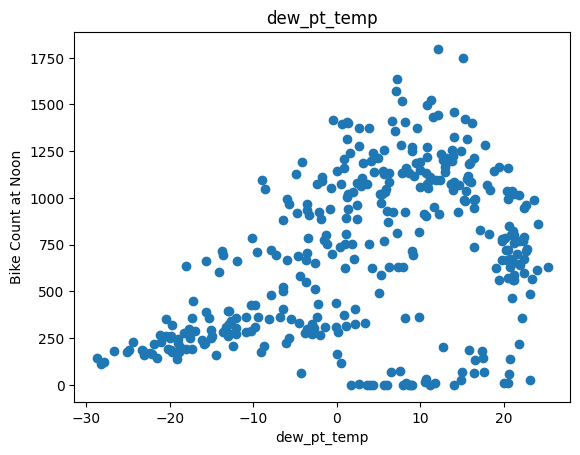

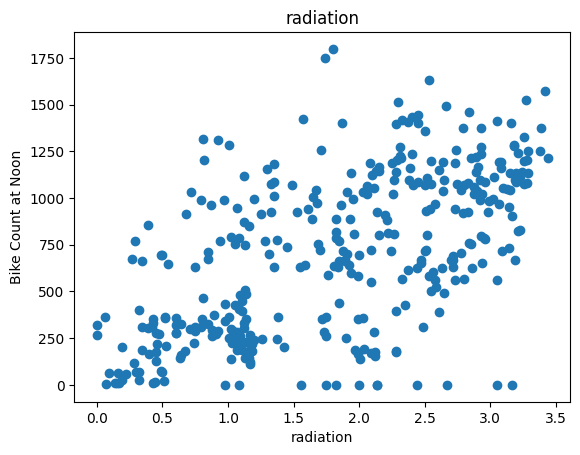

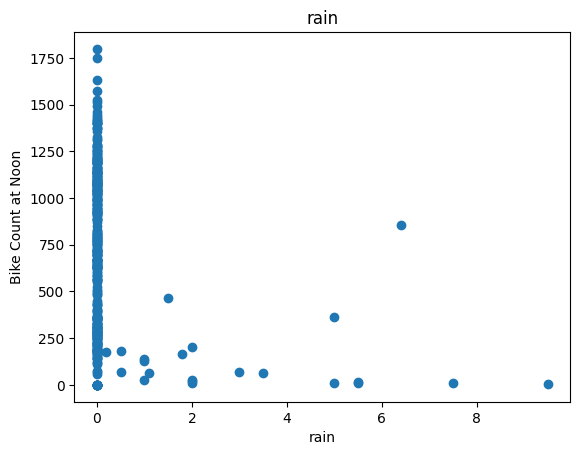

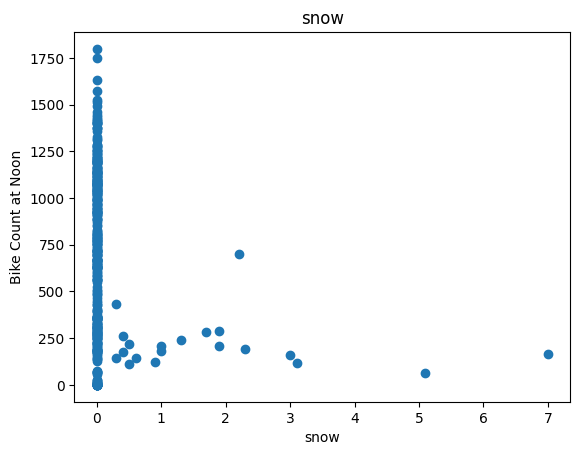

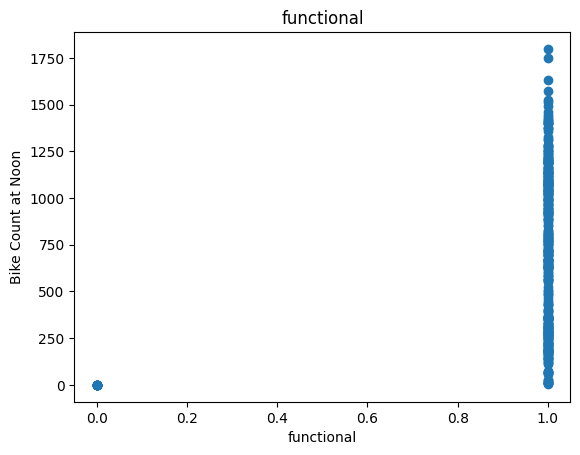

In [50]:
for label in df.columns[1:]:
    plt.scatter(df[label],df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()


In [51]:
df = df.drop(["wind","visibility","functional"],axis=1)

In [52]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train/Valid/test Dataset

In [53]:
train, val , test = np.split(df.sample(frac=1),[int(0.6*len(df)), int(0.8*len(df))])

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [54]:
def get_xy(dataframe,y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if  x_labels is None:
        X = dataframe[(c for c in dataframe.columns if c!=y_label)].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1 ,1)
    data = np.hstack((X,y))

    return data, X, y


In [55]:
_, X_train_temp, y_train_temp =get_xy(train,"bike_count", x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test,"bike_count", x_labels=['temp'])

In [56]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [57]:
# print(temp_reg.coef_, temp_reg.intercept_)
temp_reg.score(X_test_temp ,y_test_temp)

0.3541513914643436

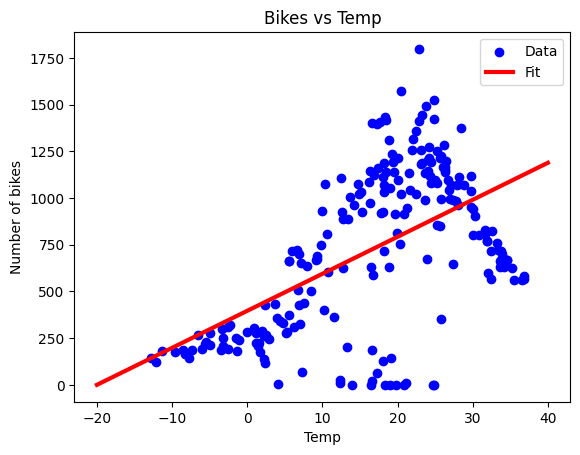

In [58]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

### Multiple Linear Regression

In [59]:
train, val , test = np.split(df.sample(frac=1),[int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [60]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [61]:
all_reg.score(X_test_all, y_test_all)

0.5162105639464727

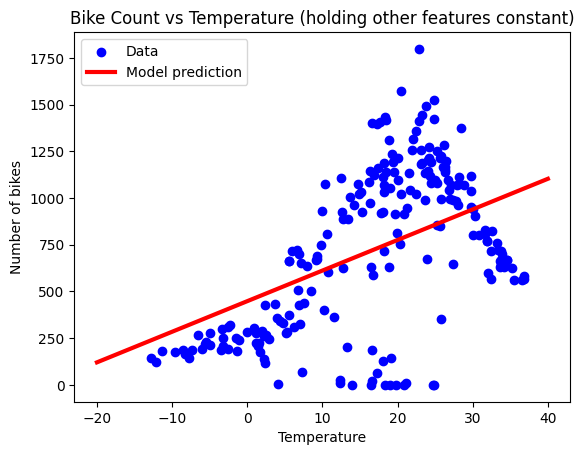

In [62]:
# Make a temperature range
x = np.linspace(-20, 40, 100)

# Create a matrix of mean feature values (shape = [100, 6])
X_plot = np.tile(X_train_all.mean(axis=0), (100, 1))

# Replace the temperature column with our range
temp_index = list(df.columns[1:]).index("temp")
X_plot[:, temp_index] = x

# Predict using the full model
y_pred = all_reg.predict(X_plot)

# Now plot
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
plt.plot(x, y_pred, label="Model prediction", color="red", linewidth=3)
plt.legend()
plt.title("Bike Count vs Temperature (holding other features constant)")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

### Regression With Nueral NetWork

In [63]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

In [64]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [66]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss="mean_squared_error")

In [67]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    validation_data = (X_val_temp, y_val_temp)
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - loss: 706614.7500 - val_loss: 619344.8750
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 705289.6875 - val_loss: 618309.1875
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 703961.5000 - val_loss: 617273.7500
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 702642.1875 - val_loss: 616244.0000
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 701318.3125 - val_loss: 615216.6875
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 699979.1250 - val_loss: 614196.8125
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 698709.6250 - val_loss: 613167.0625
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 697387.6875 - val_loss: 612146.9375
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 696099.7500 - val_loss: 611125.4375
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 694755.9375 - val_loss: 610117.8125
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

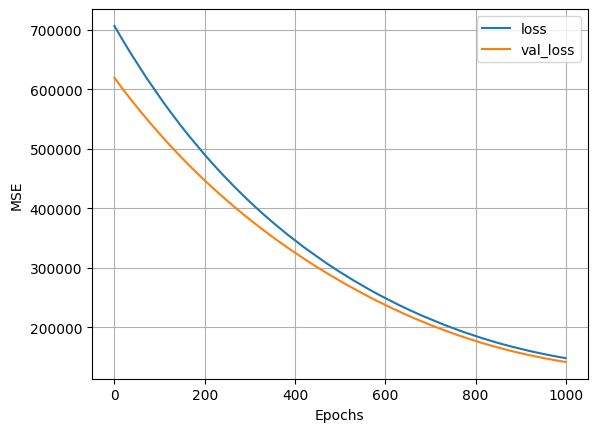

In [68]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


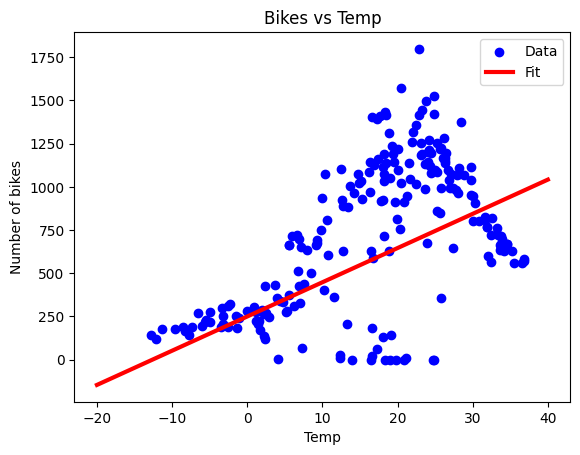

In [69]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)),
         label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

### Nueral Net

In [70]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [71]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp,y_val_temp),
    verbose=0,epochs=100
)

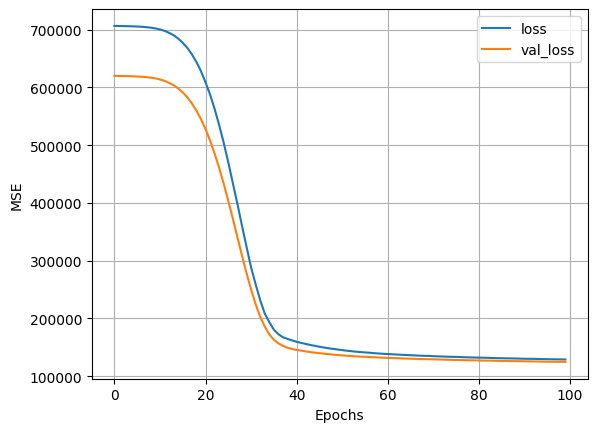

In [72]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


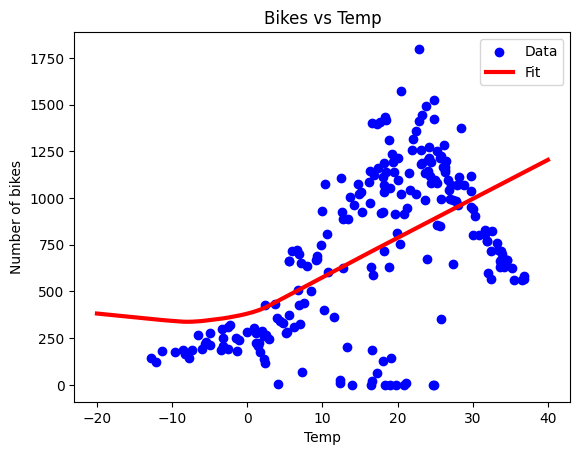

In [73]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)),
         label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [77]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)



In [78]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss="mean_squared_error")

In [79]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

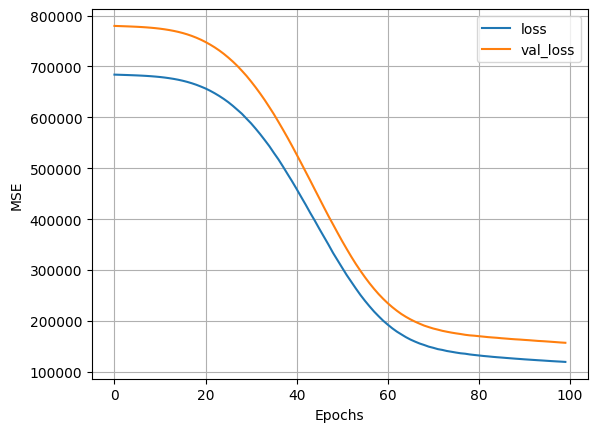

In [80]:
plot_loss(history)

In [83]:
# calculate the MSE for both linear regression and nueral net
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step


In [87]:
def MSE(y_pred, y_real):
    return np.mean(np.square(y_pred - y_real))

In [88]:
MSE(y_pred_lr,y_test_all)

np.float64(79900.04885286227)

In [89]:
MSE(y_pred_nn, y_test_all)

np.float64(108008.1926694044)

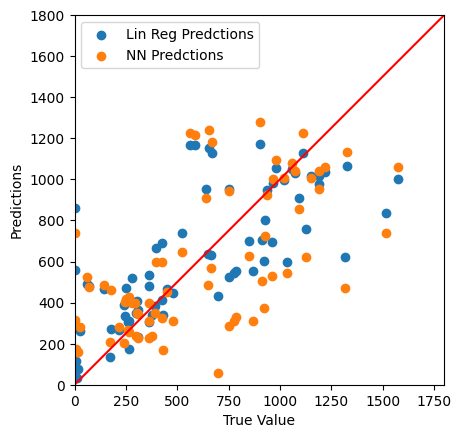

In [92]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Predctions")
plt.scatter(y_test_all, y_pred_nn, label="NN Predctions")
plt.xlabel("True Value")
plt.ylabel("Predictions")
lims = [0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ =plt.plot(lims,lims,c="red")